#Cài dặt thư viện

In [ ]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

     |████████████████████████████████| 88 kB 3.4 MB/s 
     |████████████████████████████████| 511.7 MB 6.0 kB/s 
     |████████████████████████████████| 438 kB 66.3 MB/s 
     |████████████████████████████████| 1.6 MB 47.8 MB/s 
     |████████████████████████████████| 5.8 MB 43.2 MB/s 


In [ ]:
from typing import Dict, Text

import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

#EDA

In [ ]:
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
import sklearn
import sklearn.manifold

In [ ]:
# Download MovieLens data.
print("Downloading movielens data...")
from urllib.request import urlretrieve
import zipfile

urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info'))

# Load each data set (users, movies, and ratings).
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    'ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    'ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

# The movies file contains a binary feature for each genre.
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols
movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

# Since the ids start at 1, we shift them to start at 0.
users["user_id"] = users["user_id"].apply(lambda x: str(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: str(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: str(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: str(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))



Done. Dataset contains:
b'943 users\n1682 items\n100000 ratings\n'


In [ ]:
# Compute the number of movies to which a genre is assigned.
genre_occurences = movies[genre_cols].sum().to_dict()
# Compute the number of movies to which a genre is assigned.
pd.DataFrame([genre_occurences])

,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,2,251,135,42,122,505,109,50,725,22,24,92,56,61,247,101,251,71,27


##User

In [ ]:
users

,user_id,age,sex,occupation,zip_code
0,0,24,M,technician,85711
1,1,53,F,other,94043
2,2,23,M,writer,32067
3,3,24,M,technician,43537
4,4,33,F,other,15213
...,...,...,...,...,...
938,938,26,F,student,33319
939,939,32,M,administrator,02215
940,940,20,M,student,97229
941,941,48,F,librarian,78209


In [ ]:
users.describe()

,age
count,943.000000
mean,34.051962
std,12.192740
min,7.000000
25%,25.000000
50%,31.000000
75%,43.000000
max,73.000000


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


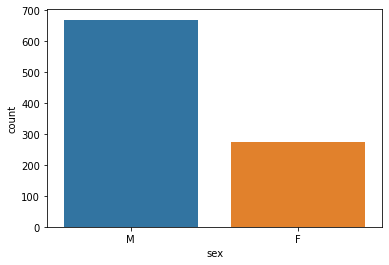

In [ ]:
sns.countplot(users['sex'])
plt.show()

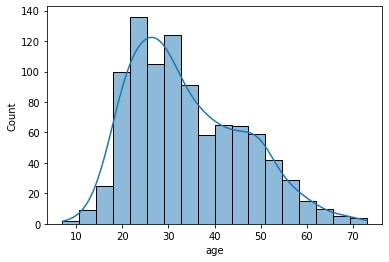

In [ ]:
sns.histplot(users['age'], kde=True)

In [ ]:
users.groupby('occupation').count()['user_id']

occupation
administrator     79
artist            28
doctor             7
educator          95
engineer          67
entertainment     18
executive         32
healthcare        16
homemaker          7
lawyer            12
librarian         51
marketing         26
none               9
other            105
programmer        66
retired           14
salesman          12
scientist         31
student          196
technician        27
writer            45
Name: user_id, dtype: int64

##Rating

In [ ]:
ratings

,user_id,movie_id,rating,unix_timestamp
0,195,241,3.0,881250949
1,185,301,3.0,891717742
2,21,376,1.0,878887116
3,243,50,2.0,880606923
4,165,345,1.0,886397596
...,...,...,...,...
99995,879,475,3.0,880175444
99996,715,203,5.0,879795543
99997,275,1089,1.0,874795795
99998,12,224,2.0,882399156


In [ ]:
Ratings=pd.DataFrame(ratings.groupby("movie_id").mean()['rating'])
Ratings['number of ratings']=pd.DataFrame(ratings.groupby("movie_id").count()["rating"])
print(Ratings.head(10))

            rating  number of ratings
movie_id                             
0         3.878319                452
1         3.206107                131
10        3.847458                236
100       3.260274                 73
1000      2.000000                 17
1001      1.875000                  8
1002      2.250000                  8
1003      3.111111                  9
1004      3.681818                 22
1005      2.826087                 23


<function matplotlib.pyplot.show>

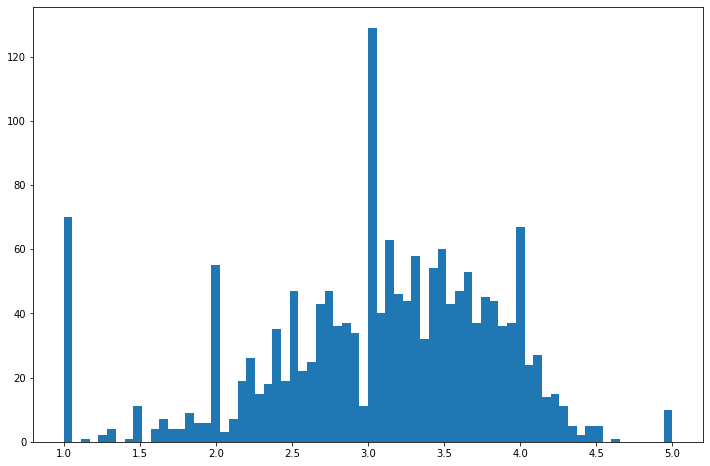

In [ ]:
plt.figure(figsize=(12,8))
plt.hist(Ratings['rating'], bins=70)
plt.show

In [ ]:
movies_ratings=movies.merge(Ratings, on='movie_id')
movies_ratings

,movie_id,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,rating,number of ratings
0,0,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,1995,3.878319,452
1,1,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,1,0,0,1995,3.206107,131
2,2,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,1,0,0,1995,3.033333,90
3,3,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,1995,3.550239,209
4,4,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,1,0,0,1995,3.302326,86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1677,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,1998,1.000000,1
1678,1678,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,1,0,1,0,0,1998,3.000000,1
1679,1679,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,1,0,0,0,0,1998,2.000000,1
1680,1680,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,1994,3.000000,1


#Basic ReSys 2 Tower

`Matrix Factorization` (MF) is a classic collaborative filtering method to learn some `latent factors` (latent features) from `user_id`, `item_id` and `rating` features and represent **users** and **items** by latent (embedding) vectors.

<p align="center">
  <img width="826" height="398" src="https://raw.githubusercontent.com/xei/recommender-system-tutorial/main/assets/mf.png">
</p>

Matrix Factorization method only uses `user_id` and `candidate_id` features collaboratively to learn the `latent features`. In fact it doesn't care about other side-features like `candidate_description`, `price`, `user_comment`, etc.

To involve side-features as well as ids while learning latent features (embeddings), we can use deep neural network (DNN) architectures like `softmax` or `two-tower` neural models.

<p align="center">
  <img width="540" height="340" src="https://raw.githubusercontent.com/xei/recommender-system-tutorial/main/assets/tensorflow_two_tower.gif">
</p>

YouTube two-tower neural model uses side-features to represent queries and candidates in an abstract high-dimentional embedding vector.

<p align="center">
  <img width="540" height="340" src="https://raw.githubusercontent.com/xei/recommender-system-tutorial/main/assets/youtube_retrieval.png">
</p>

In [ ]:
# Ratings data.
ratings = tfds.load('movielens/100k-ratings', split="train")
# Features of all the available movies.
movies = tfds.load('movielens/100k-movies', split="train")

# Select the basic features.
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"]
})
movies = movies.map(lambda x: x["movie_title"])

In [ ]:
tf.random.set_seed(42)
# More info: https://www.tensorflow.org/api_docs/python/tf/random/set_seed

# Shuffle the elements of the dataset randomly.
ratings_dataset_shuffled = ratings.shuffle(
    # the new dataset will be sampled from a buffer window of first `buffer_size`
    # elements of the dataset
    buffer_size=100_000,
    # set the random seed that will be used to create the distribution.
    seed=42,
    # `list(dataset.as_numpy_iterator()` yields different result for each call
    # Because reshuffle_each_iteration defaults to True.
    reshuffle_each_iteration=False
)
# More info: https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
trainset_size = 0.8 * ratings.__len__().numpy()
ratings_trainset = ratings_dataset_shuffled.take(trainset_size)
ratings_testset = ratings_dataset_shuffled.skip(trainset_size)

## Build the Retrieval (Candidate Generation) task

It is about selecting an initial set of hundreds of candidates from all possible candidates. The main objective of this model is to efficiently weed out all candidates that the user is not interested in. Because the retrieval model may be dealing with millions of candidates, **it has to be computationally efficient**.

A retrieval system is a model that predicts a set of movies from the catalogue that the user is likely to watch. So the train set should be expressesing which movies the users watched, and which they did not. for example:
```
[
  (('user1', 'Star Wars'), POSITIVE),
  (('user1', 'Harry Potter'), NEGATIVE),
  ...
]
```
So we treat Movielens as an `implicit feedback dataset`, where users' watches tell us which things they prefer to see and which they'd rather not see. This means that every movie a user rated (so watched!), no matter the given rating, is an **implicit positive example**, and every movie they have not rated (not seen!) is an **implicit negative example**.

In [ ]:
user_ids_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
user_ids_vocabulary.adapt(ratings.map(lambda x: x["user_id"]))

movie_titles_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
movie_titles_vocabulary.adapt(movies)

The similarity between the query representation (query embedding vector) and the candiate representation (candidate embedding vector) a.k.a. `affinity score` can be calcualted by dot-product (or other similarity measures). The K-nearest candidates (candidates with higher affinity scores) will be chosen for the final list.

In our training data we only have positive (user, movie) pairs. To figure out how good our model is, we need to compare the affinity score that the model calculates for this positive pair to the scores of all the other possible candidates: if the score for the positive pair is higher than for all other possible candidates, our model is highly accurate.

To measure the performance of a retrieval task, `factorized top-K categorical accuracy` metrics over a corpus of candidates can be used. These metrics measure how good the model is at picking the true candidate out of **all possible candidates** in the system.

For example, a `top-5 categorical accuracy` metric of `0.2` would tell us that, on average, the true positive is in the top 5 retrieved items 20% of the time.

In [ ]:
class MovieLensModel(tfrs.Model):
  # We derive from a custom base class to help reduce boilerplate. Under the hood,
  # these are still plain Keras Models.

  def __init__(
      self,
      user_model: tf.keras.Model,
      movie_model: tf.keras.Model,
      task: tfrs.tasks.Retrieval):
    super().__init__()

    # Set up user and movie representations.
    self.user_model = user_model
    self.movie_model = movie_model

    # Set up a retrieval task.
    self.task = task

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    # Define how the loss is computed.

    user_embeddings = self.user_model(features["user_id"])
    movie_embeddings = self.movie_model(features["movie_title"])

    return self.task(user_embeddings, movie_embeddings)

In [ ]:
# Define user and movie models.
user_model = tf.keras.Sequential([
    user_ids_vocabulary,
    tf.keras.layers.Embedding(user_ids_vocabulary.vocab_size(), 64)
])
movie_model = tf.keras.Sequential([
    movie_titles_vocabulary,
    tf.keras.layers.Embedding(movie_titles_vocabulary.vocab_size(), 64)
])
# Define your objectives.
task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
    movies.batch(128).map(movie_model)
  )
)

In [ ]:
retrieval_cached_ratings_trainset = \
  ratings_trainset.shuffle(100_000).batch(8192).cache()
retrieval_cached_ratings_testset = \
  ratings_testset.batch(4096).cache()

In [ ]:
# Create a retrieval model.
model = MovieLensModel(user_model, movie_model, task)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

# Train for 5 epochs.
history=model.fit(retrieval_cached_ratings_trainset,
    validation_data=retrieval_cached_ratings_testset,
    validation_freq=1,
    epochs=5)

Epoch 1/5
10/10 [==============================] - 34s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0025 - factorized_top_k/top_5_categorical_accuracy: 0.0237 - factorized_top_k/top_10_categorical_accuracy: 0.0550 - factorized_top_k/top_50_categorical_accuracy: 0.2649 - factorized_top_k/top_100_categorical_accuracy: 0.4270 - loss: 63579.7021 - regularization_loss: 0.0000e+00 - total_loss: 63579.7021 - val_factorized_top_k/top_1_categorical_accuracy: 1.5000e-04 - val_factorized_top_k/top_5_categorical_accuracy: 0.0015 - val_factorized_top_k/top_10_categorical_accuracy: 0.0050 - val_factorized_top_k/top_50_categorical_accuracy: 0.0959 - val_factorized_top_k/top_100_categorical_accuracy: 0.2256 - val_loss: 28714.6211 - val_regularization_loss: 0.0000e+00 - val_total_loss: 28714.6211
Epoch 2/5
10/10 [==============================] - 31s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0036 - factorized_top_k/top_5_categorical_accuracy: 0.0328 - factorized_top_k/top_10_

In [ ]:
# Use brute-force search to set up retrieval using the trained representations.
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
index.index_from_dataset(
    movies.batch(1024).map(lambda title: (title, model.movie_model(title))))

# Get some recommendations.
_, titles = index(np.array(["42"]))
print(f"Top 3 recommendations for user 42: {titles[0, :3]}")

Top 3 recommendations for user 42: [b'Rent-a-Kid (1995)' b'Fearless (1993)' b'Unstrung Heroes (1995)']


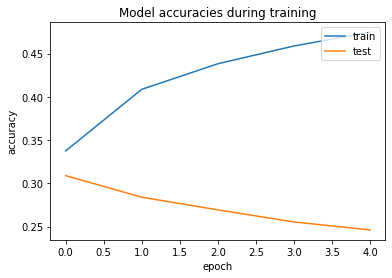

In [ ]:
import matplotlib.pyplot as plt
# Plot changes in model accuracy during training
plt.plot(history.history["factorized_top_k/top_100_categorical_accuracy"])
plt.plot(history.history["val_factorized_top_k/top_100_categorical_accuracy"])
plt.title("Model accuracies during training")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["train", "test"], loc="upper right")
plt.show()